In [ ]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

# Zadanie

Dysponujesz danymi z portalu Our World in Data dotyczącymi:
- Pierwotnej konsumpcji energii
- Emisji CO2 z poszczególnych lat dla różnych krajów

## Część 1: Plik CSV
Utwórz plik CSV zawierający połączone dane dla Polski:
- konsumpcja energii pierwotnej
- emisja CO2
- dane z poszczególnych lat

## Część 2: Plik Excel
Stwórz plik Excel z osobnymi zakładkami dla każdego kraju:
- UE
- USA
- Chiny
- Indie

Każda zakładka powinna zawierać dane o konsumpcji energii i emisji CO2.

## Część 3: Baza danych SQLite
Utwórz bazę danych SQLite z tabelą zawierającą:
- kraj
- rok
- emisja CO2
- konsumpcja energii

Dane powinny obejmować: Polskę, Niemcy i Hiszpanię.

## Część 4: Analiza i wizualizacja
Na podstawie danych z pliku Excel i bazy SQLite utwórz wykresy:
- emisja CO2 w zależności od roku (dla wybranego kraju)
- konsumpcja energii pierwotnej w zależności od roku (dla wybranego kraju)
- **dla chęnych szukanie koreacji**

In [ ]:
#1
import pandas as pd


rows = [
    {"Kraj": "Polska", "Rok": 2020, "Ilość[Mtoe]": 92.94},
    {"Kraj": "Polska", "Rok": 2021, "Ilość[Mtoe]": 92.00},
    {"Kraj": "Polska", "Rok": 2022, "Ilość[Mtoe]": 90.25},
    {"Kraj": "Polska", "Rok": 2023, "Ilość[Mtoe]": 91.94},
    {"Kraj": "Polska", "Rok": 2024, "Ilość[Mtoe]": 95.50},
]
rows1=[
     {"Kraj": "Polska", "Rok": 2020, "Ilość[w milionach ton ekwiwalentu]": 371.9},
    {"Kraj": "Polska", "Rok": 2021, "Ilość[w milionach ton ekwiwalentu]": 399.9 },
    {"Kraj": "Polska", "Rok": 2022, "Ilość[w milionach ton ekwiwalentu]": 321.9 },
    {"Kraj": "Polska", "Rok": 2023, "Ilość[w milionach ton ekwiwalentu]": 348.0},
    {"Kraj": "Polska", "Rok": 2024, "Ilość[w milionach ton ekwiwalentu]": 335.0},
]
df_energy = pd.DataFrame(rows).rename(
    columns={"Ilość[Mtoe]": "Konsumpcja_energii[Mtoe]"}
)
df_co2 = pd.DataFrame(rows1).rename(
    columns={"Ilość[w milionach ton ekwiwalentu]": "Emisja_CO2[MtCO2e]"}
)

df_merged = (
    pd.merge(df_energy, df_co2, on=["Kraj", "Rok"], how="inner")
      .sort_values(["Kraj", "Rok"])
      .reset_index(drop=True)
)

print(df_merged)


df_merged.to_csv("polska_energy_co2.csv", index=False, encoding="utf-8")
print("Zapisano: polska_energy_co2.csv")


     Kraj   Rok  Konsumpcja_energii[Mtoe]  Emisja_CO2[MtCO2e]
0  Polska  2020                     92.94               371.9
1  Polska  2021                     92.00               399.9
2  Polska  2022                     90.25               321.9
3  Polska  2023                     91.94               348.0
4  Polska  2024                     95.50               335.0
Zapisano: polska_energy_co2.csv


In [14]:
#2
import sqlite3
import pandas as pd
import openpyxl
import re
import pandas as pd

ENERGY_CSV = "primary-energy-cons.csv"
CO2_CSV = "co2-emissions-per-capita.csv"
OUT_XLSX = "Energy_CO2_by_country.xlsx"

def normalize_entity(s: str) -> str:
    """Ujednolicenie nazwy encji: usunięcie wszystkiego poza literami/cyframi i spacje -> pojedyncze."""
    s = str(s).strip().upper()
    s = re.sub(r"[^A-Z0-9 ]+", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s


energy = pd.read_csv(ENERGY_CSV)
co2 = pd.read_csv(CO2_CSV)


def colmap(df):
    return {c.lower(): c for c in df.columns}

e_cols = colmap(energy); c_cols = colmap(co2)

ENTITY_E = e_cols.get("entity")
YEAR_E   = e_cols.get("year")
CODE_E   = e_cols.get("code")
ENERGY_VAL = next((c for c in energy.columns
                   if "primary" in c.lower() and "energy" in c.lower() and ("consumption" in c.lower() or "cons" in c.lower())), None)

ENTITY_C = c_cols.get("entity")
YEAR_C   = c_cols.get("year")
CODE_C   = c_cols.get("code")
CO2_VAL  = next((c for c in co2.columns
                 if ("co2" in c.lower() or "co₂" in c.lower()) and "per" in c.lower() and "capita" in c.lower()), None)

if not all([ENTITY_E, YEAR_E, ENERGY_VAL, ENTITY_C, YEAR_C, CO2_VAL]):
    raise RuntimeError("Brak wymaganych kolumn w jednym z CSV. Sprawdź nagłówki.")


energy = energy[[ENTITY_E, YEAR_E] + ([CODE_E] if CODE_E else []) + [ENERGY_VAL]].rename(
    columns={ENTITY_E: "Entity", YEAR_E: "Year", (CODE_E or "Code"): "Code", ENERGY_VAL: "Primary energy consumption (TWh)"}
)
co2 = co2[[ENTITY_C, YEAR_C] + ([CODE_C] if CODE_C else []) + [CO2_VAL]].rename(
    columns={ENTITY_C: "Entity", YEAR_C: "Year", (CODE_C or "Code"): "Code", CO2_VAL: "CO2 emissions (per capita)"}
)


energy["Entity_norm"] = energy["Entity"].map(normalize_entity)
co2["Entity_norm"]    = co2["Entity"].map(normalize_entity)


targets = {
    "UE":    {"EUROPEAN UNION", "EUROPEAN UNION 27", "EUROPEAN UNION 28"},
    "USA":   {"UNITED STATES"},
    "Chiny": {"CHINA"},
    "Indie": {"INDIA"},
}

def make_sheet(sheet_name, accepted_norms):
    e = energy[energy["Entity_norm"].isin(accepted_norms)].copy()
    c = co2[co2["Entity_norm"].isin(accepted_norms)].copy()


    df = pd.merge(
        e.drop(columns=["Entity", "Code"], errors="ignore"),
        c.drop(columns=["Entity", "Code"], errors="ignore"),
        on=["Year", "Entity_norm"],
        how="outer",
        sort=True
    )


    name_map = pd.concat([
        energy.loc[energy["Entity_norm"].isin(accepted_norms), ["Entity_norm", "Entity"]],
        co2.loc[co2["Entity_norm"].isin(accepted_norms), ["Entity_norm", "Entity"]],
    ]).dropna().drop_duplicates().set_index("Entity_norm")["Entity"].to_dict()

    df["Entity"] = df["Entity_norm"].map(name_map)
    df["Entity"].fillna(sheet_name, inplace=True)


    ordered = ["Entity", "Year", "Primary energy consumption (TWh)", "CO2 emissions (per capita)", "Entity_norm"]
    ordered += [c for c in df.columns if c not in ordered]
    df = df[ordered].sort_values(["Year"]).reset_index(drop=True)

    return df

with pd.ExcelWriter(OUT_XLSX, engine="openpyxl") as writer:
    for sheet, norms in targets.items():
        sheet_df = make_sheet(sheet, norms)
        sheet_df.to_excel(writer, sheet_name=sheet, index=False)

print(f"Zapisano: {OUT_XLSX}")


Zapisano: Energy_CO2_by_country.xlsx


/tmp/ipython-input-2980527944.py:84: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Entity"].fillna(sheet_name, inplace=True)
/tmp/ipython-input-2980527944.py:84: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usi

In [17]:
#3
import re
import sqlite3
import pandas as pd
from pathlib import Path

ENERGY_CSV = "primary-energy-cons.csv"
CO2_CSV = "co2-emissions-per-capita.csv"
DB_PATH = "energy_co2.sqlite"
TABLE_NAME = "dane"

def normalize_entity(s: str) -> str:
    s = str(s).strip().upper()
    s = re.sub(r"[^A-Z0-9 ]+", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

energy_raw = pd.read_csv(ENERGY_CSV)
co2_raw = pd.read_csv(CO2_CSV)

def cmap(df):
    return {c.lower(): c for c in df.columns}

e_cols = cmap(energy_raw)
c_cols = cmap(co2_raw)

ENTITY_E = e_cols.get("entity"); YEAR_E = e_cols.get("year")
ENERGY_VAL = next((c for c in energy_raw.columns if "primary" in c.lower() and "energy" in c.lower() and ("consumption" in c.lower() or "cons" in c.lower())), None)
ENTITY_C = c_cols.get("entity"); YEAR_C = c_cols.get("year")
CO2_VAL = next((c for c in co2_raw.columns if ("co2" in c.lower() or "co₂" in c.lower()) and "per" in c.lower() and "capita" in c.lower()), None)

if not all([ENTITY_E, YEAR_E, ENERGY_VAL, ENTITY_C, YEAR_C, CO2_VAL]):
    raise RuntimeError("Brak wymaganych kolumn w którymś z plików CSV.")

energy = energy_raw[[ENTITY_E, YEAR_E, ENERGY_VAL]].rename(
    columns={ENTITY_E: "Entity", YEAR_E: "Year", ENERGY_VAL: "Primary energy consumption (TWh)"}
)
co2 = co2_raw[[ENTITY_C, YEAR_C, CO2_VAL]].rename(
    columns={ENTITY_C: "Entity", YEAR_C: "Year", CO2_VAL: "CO2 emissions (per capita)"}
)

energy["Entity_norm"] = energy["Entity"].map(normalize_entity)
co2["Entity_norm"] = co2["Entity"].map(normalize_entity)

targets = {"POLAND": "Polska", "GERMANY": "Niemcy", "SPAIN": "Hiszpania"}

energy_sel = energy[energy["Entity_norm"].isin(targets.keys())].copy()
co2_sel = co2[co2["Entity_norm"].isin(targets.keys())].copy()

df = pd.merge(energy_sel, co2_sel, on=["Year", "Entity_norm"], how="outer", sort=True)
df["kraj"] = df["Entity_norm"].map(targets)
df_out = df.rename(columns={"Year": "rok", "CO2 emissions (per capita)": "emisja_CO2", "Primary energy consumption (TWh)": "konsumpcja_energii"})[["kraj", "rok", "emisja_CO2", "konsumpcja_energii"]].sort_values(["kraj", "rok"]).reset_index(drop=True)

db_path = Path(DB_PATH)
with sqlite3.connect(db_path) as conn:
    df_out.to_sql(TABLE_NAME, conn, if_exists="replace", index=False)
    cur = conn.cursor()
    cur.execute(f"CREATE INDEX IF NOT EXISTS idx_{TABLE_NAME}_kraj ON {TABLE_NAME}(kraj);")
    cur.execute(f"CREATE INDEX IF NOT EXISTS idx_{TABLE_NAME}_kraj_rok ON {TABLE_NAME}(kraj, rok);")
    conn.commit()

with sqlite3.connect(db_path) as conn:
    df_db = pd.read_sql_query(f"SELECT * FROM {TABLE_NAME} ORDER BY kraj, rok;", conn)

print(df_db.to_string(index=False))
print(f"\nWierszy: {len(df_db)}  |  Baza: {db_path.resolve()}  |  Tabela: {TABLE_NAME}")


     kraj  rok  emisja_CO2  konsumpcja_energii
Hiszpania 1830    0.000281                 NaN
Hiszpania 1831    0.000279                 NaN
Hiszpania 1832    0.000277                 NaN
Hiszpania 1833    0.000275                 NaN
Hiszpania 1834    0.000274                 NaN
Hiszpania 1835    0.000272                 NaN
Hiszpania 1836    0.001620                 NaN
Hiszpania 1837    0.002682                 NaN
Hiszpania 1838    0.001865                 NaN
Hiszpania 1839    0.003440                 NaN
Hiszpania 1840    0.002629                 NaN
Hiszpania 1841    0.007312                 NaN
Hiszpania 1842    0.010117                 NaN
Hiszpania 1843    0.012112                 NaN
Hiszpania 1844    0.014080                 NaN
Hiszpania 1845    0.019072                 NaN
Hiszpania 1846    0.019451                 NaN
Hiszpania 1847    0.017817                 NaN
Hiszpania 1848    0.019943                 NaN
Hiszpania 1849    0.022047                 NaN
Hiszpania 185

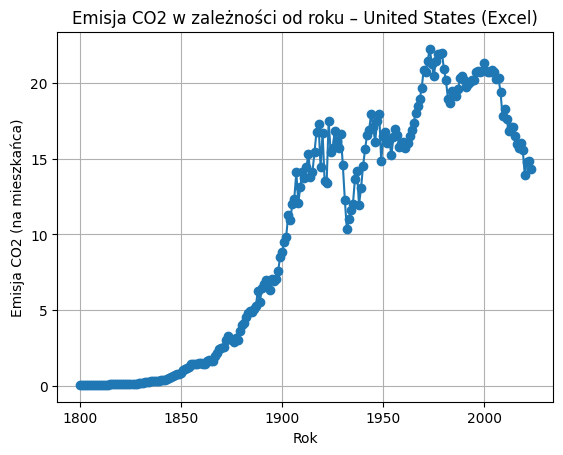

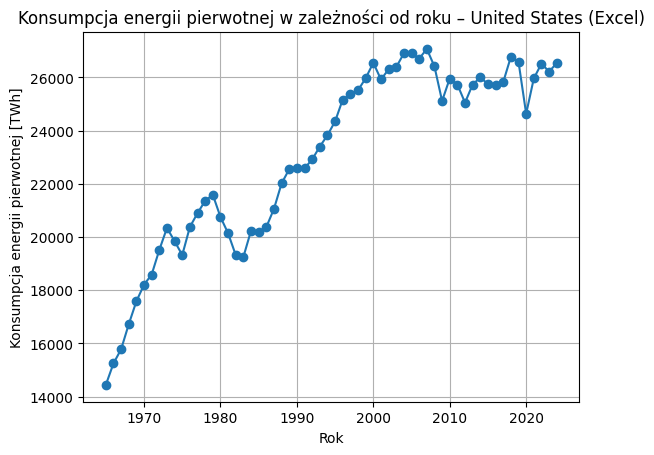

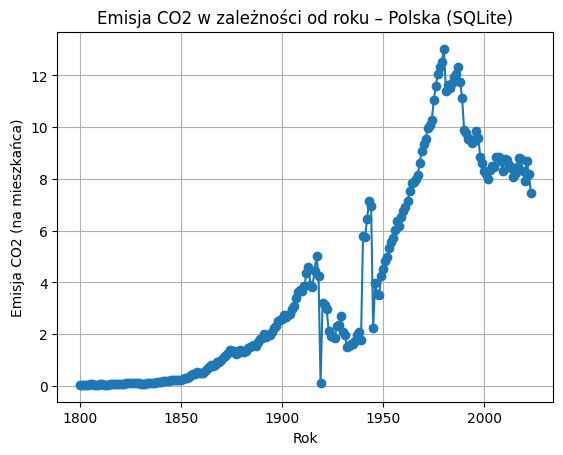

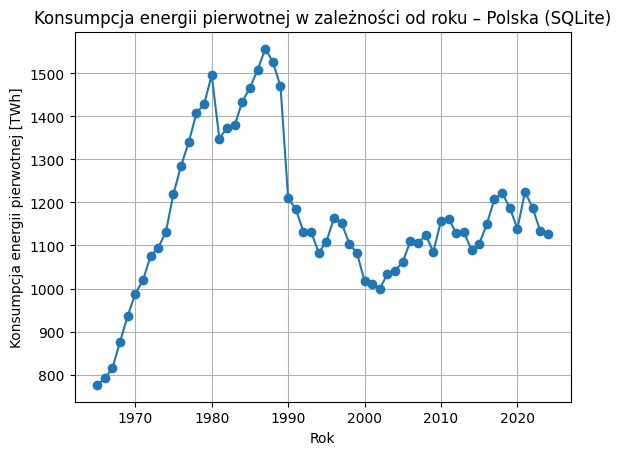

In [19]:
#4
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

EXCEL_PATH = "Energy_CO2_by_country.xlsx"
DB_PATH = "energy_co2.sqlite"
TABLE_NAME = "dane"

def load_from_excel(sheet_name: str) -> pd.DataFrame:
    """
    Wczytaj dane z Excela (plik z zadania #2) dla wybranego arkusza:
    np. 'UE', 'USA', 'Chiny', 'Indie'.
    """
    df = pd.read_excel(EXCEL_PATH, sheet_name=sheet_name)

    # ujednolicenie nazw kolumn
    df = df.rename(columns={
        "Entity": "kraj",
        "Year": "rok",
        "CO2 emissions (per capita)": "emisja_CO2",
        "Primary energy consumption (TWh)": "konsumpcja_energii"
    })

    # sortowanie po roku
    df = df.sort_values("rok").reset_index(drop=True)
    return df


def load_from_sqlite(country_name: str) -> pd.DataFrame:
    """
    Wczytaj dane z bazy SQLite (plik z zadania #3) dla wybranego kraju:
    np. 'Polska', 'Niemcy', 'Hiszpania'.
    """
    with sqlite3.connect(DB_PATH) as conn:
        query = f"""
        SELECT kraj, rok, emisja_CO2, konsumpcja_energii
        FROM {TABLE_NAME}
        WHERE kraj = ?
        ORDER BY rok;
        """
        df = pd.read_sql_query(query, conn, params=(country_name,))
    return df

def plot_country(df: pd.DataFrame, country_label: str, source_label: str):
    """
    Rysuje dwa wykresy:
    1) emisja CO2 w zależności od roku
    2) konsumpcja energii pierwotnej w zależności od roku
    """
    df = df.sort_values("rok")

    plt.figure()
    plt.plot(df["rok"], df["emisja_CO2"], marker="o")
    plt.xlabel("Rok")
    plt.ylabel("Emisja CO2 (na mieszkańca)")
    plt.title(f"Emisja CO2 w zależności od roku – {country_label} ({source_label})")
    plt.grid(True)

    plt.figure()
    plt.plot(df["rok"], df["konsumpcja_energii"], marker="o")
    plt.xlabel("Rok")
    plt.ylabel("Konsumpcja energii pierwotnej [TWh]")
    plt.title(f"Konsumpcja energii pierwotnej w zależności od roku – {country_label} ({source_label})")
    plt.grid(True)

    plt.show()



if __name__ == "__main__":
    selected_sheet = "USA"
    df_excel = load_from_excel(selected_sheet)
    country_excel_label = df_excel["kraj"].iloc[0]
    plot_country(df_excel, country_excel_label, "Excel")
    selected_country = "Polska"
    df_sqlite = load_from_sqlite(selected_country)
    plot_country(df_sqlite, selected_country, "SQLite")


In [ ]:
df_primary_energy = pd.read_csv("/content/primary-energy-cons.csv")
df_primary_energy.head()

,Entity,Code,Year,Primary energy consumption (TWh)
0,Afghanistan,AFG,1980,6.337187
1,Afghanistan,AFG,1981,7.289555
2,Afghanistan,AFG,1982,7.889244
3,Afghanistan,AFG,1983,9.882159
4,Afghanistan,AFG,1984,9.929878
